## Identify the Sentiments

Sentiment analysis remains one of the key problems that has seen extensive application of natural language processing. This time around, given the tweets from customers about various tech firms who manufacture and sell mobiles, computers, laptops, etc, the task is to identify if the tweets have a negative sentiment towards such companies or products.

 

Evaluation Metric
The metric used for evaluating the performance of classification model would be weighted F1-Score.

Data
train.csv - For training the models, we provide a labelled dataset of 7920 tweets. The dataset is provided in the form of a csv file with each line storing a tweet id, its label and the tweet.

test.csv - The test data file contains only tweet ids and the tweet text with each tweet in a new line.

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
pd.set_option('display.notebook_repr_html', True)

In [1184]:
train = pd.read_csv("train.csv")
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [1185]:
test = pd.read_csv("test.csv")
test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [1186]:
df = pd.concat([train,test])
df.head()

,id,label,tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...
2,3,0.0,We love this! Would you go? #talk #makememorie...
3,4,0.0,I'm wired I know I'm George I was made that wa...
4,5,1.0,What amazing service! Apple won't even talk to...


In [1187]:
train.shape, test.shape, df.shape

((7920, 3), (1953, 2), (9873, 3))

In [1188]:
df.dtypes

id         int64
label    float64
tweet     object
dtype: object

In [1189]:
df.isnull().sum()    # label is expected one as test dataset does not have label

id          0
label    1953
tweet       0
dtype: int64

### EDA

In [1190]:
df['label'].value_counts()

0.0    5894
1.0    2026
Name: label, dtype: int64

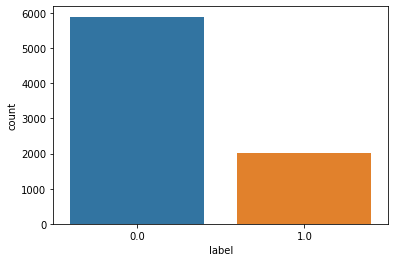

In [1191]:
sns.countplot(df['label'])

In [1192]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)
    
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    #Convert to lowercase to maintain consistency
    text = text.lower()
    
    #remove double spaces 
    text = re.sub('\s+', ' ',text)
    
    return text

df["clean_tweet"] = df['tweet'].apply(lambda x: clean_text(x))

In [1193]:
df.head()

,id,label,tweet,clean_tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test android apps beaut...
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...,finally a transparant silicon case thanks to m...
2,3,0.0,We love this! Would you go? #talk #makememorie...,we love this would you go talk makememories un...
3,4,0.0,I'm wired I know I'm George I was made that wa...,i'm wired i know i'm george i was made that wa...
4,5,1.0,What amazing service! Apple won't even talk to...,what amazing service apple won't even talk to ...


In [1194]:
#defining stop words
STOP_WORDS = ['a', 'about', 'above', 'after', 'again', 'against', 'all', 'also', 'am', 'an', 'and',
              'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below',
              'between', 'both', 'but', 'by', 'can', "can't", 'cannot', 'com', 'could', "couldn't", 'did',
              "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'else', 'ever',
              'few', 'for', 'from', 'further', 'get', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having',
              'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how',
              "how's", 'however', 'http', 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it',
              "it's", 'its', 'itself', 'just', 'k', "let's", 'like', 'me', 'more', 'most', "mustn't", 'my', 'myself',
              'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'otherwise', 'ought', 'our', 'ours',
              'ourselves', 'out', 'over', 'own', 'r', 'same', 'shall', "shan't", 'she', "she'd", "she'll", "she's",
              'should', "shouldn't", 'since', 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs',
              'them', 'themselves', 'then', 'there', "there's", 'these', 'they', "they'd", "they'll", "they're",
              "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', "wasn't",
              'we', "we'd", "we'll", "we're", "we've", 'were', "weren't", 'what', "what's", 'when', "when's", 'where',
              "where's", 'which', 'while', 'who', "who's", 'whom', 'why', "why's", 'with', "won't", 'would', "wouldn't",
              'www', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']

In [1195]:
#remove stopwords
df['cleaned_tweets'] = df['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in STOP_WORDS]))

In [1196]:
#from nltk.stem.porter import PorterStemmer
#ps = PorterStemmer()
#df['cleaned_tweets'] = df['clean_tweet'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() if word not in STOP_WORDS]))

In [1197]:
#remove stopwords
#df['cleaned_tweets'] = df['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

In [1198]:
# feature length of tweet
df['word_count'] = df['cleaned_tweets'].str.split().apply(lambda x :len(x))

In [1199]:
# drop not needed features
df_1 = df.copy()
df.drop(['tweet','clean_tweet'],axis=1,inplace=True)
#df.drop(['tweet','clean_tweet','word_count'],axis=1,inplace=True)

In [1200]:
df.head()

,id,label,cleaned_tweets,word_count
0,1,0.0,fingerprint pregnancy test android apps beauti...,12
1,2,0.0,finally transparant silicon case thanks uncle ...,11
2,3,0.0,love go talk makememories unplug relax iphone ...,10
3,4,0.0,wired know george made way iphone cute daventr...,9
4,5,1.0,amazing service apple even talk question unles...,10


### Model Building

In [1201]:
train = df[:7920]
test = df[7920:]
df_t = test.copy()

In [1202]:
train.shape, test.shape

((7920, 4), (1953, 4))

In [1203]:
X = train.drop('label',axis=1)
y = train['label']

In [1204]:
X.shape, y.shape

((7920, 3), (7920,))

In [1205]:
test.drop('label',axis=1,inplace=True)

In [1206]:
X = X['cleaned_tweets'].astype('category')
#X = X['word_count'].astype('category')
test = test['cleaned_tweets'].astype('category')
#test = test['word_count'].astype('category')

In [1207]:
#Train test Split
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 1)

- To perform further analysis we need to transform our data into a format that can be processed by our machine learning models.

- CountVectorizer does text preprocessing, tokenizing and filtering of stopwords and it builds a dictionary of features and transform documents to feature vectors.
- TfidfTransformer transforms the above vector by dividing the number of occurrences of each word in a document by the total number of words in the document. These new features are called tf or Term Frequencies.

In [1208]:
vect = CountVectorizer(max_features = 2500)
vect.fit(X)
X_train_vec = vect.transform(X)
X_test_vec = vect.transform(test)

### Random Forest

In [219]:
model = RandomForestClassifier(n_estimators=100,max_depth=5)
model.fit(X_train_vec,y)
rf = model.predict(X_test_vec)
submission = pd.DataFrame({
        "id": df_t["id"],
        "label":rf
    })

submission.to_csv('sentiments_submission.csv', index=False)

In [287]:
clf = SGDClassifier(max_iter=5, tol=None)
clf.fit(X_train_vec, y)
y_pred_SGD = clf.predict(X_test_vec)

submission = pd.DataFrame({
        "id": df_t["id"],
        "label":y_pred_SGD
    })

submission.to_csv('sentiments_submission_SGD.csv', index=False)

In [817]:
import xgboost
classifier = xgboost.XGBClassifier(n_estimators=210)
classifier.fit(X_train_vec, y)
# Predicting the Test set results
y_pred_XGB = classifier.predict(X_test_vec)
submission = pd.DataFrame({
        "id": df_t["id"],
        "label":y_pred_XGB
    })

submission.to_csv('sentiments_submission_XGB.csv', index=False)

In [285]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train_vec, y)
y_pred_log_reg = clf.predict(X_test_vec)
submission = pd.DataFrame({
        "id": df_t["id"],
        "label":y_pred_log_reg
    })

submission.to_csv('sentiments_submission_LRG.csv', index=False)

In [284]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 4)
clf.fit(X_train_vec, y)
y_pred_knn = clf.predict(X_test_vec)
submission = pd.DataFrame({
        "id": df_t["id"],
        "label":y_pred_knn
    })

submission.to_csv('sentiments_submission_knn.csv', index=False)

In [283]:
from sklearn.linear_model import Perceptron
clf = Perceptron(max_iter=6, tol=None)
clf.fit(X_train_vec, y)
y_pred_perceptron = clf.predict(X_test_vec)
submission = pd.DataFrame({
        "id": df_t["id"],
        "label":y_pred_perceptron
    })

submission.to_csv('sentiments_submission_per.csv', index=False)

#### for lightgbm features needed is in float type

In [1209]:
X_train_vec=X_train_vec.astype('float64')
X_test_vec=X_test_vec.astype('float64')

In [1210]:
X_train_vec

<7920x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 67107 stored elements in Compressed Sparse Row format>

In [1211]:
import lightgbm as lgb
train_data=lgb.Dataset(X_train_vec,label=y)
#define parameters
params = {'n_estimators':213,'objective':'binary','learning_rate':0.2,'max_depth': 10,'num_leaves':'100','min_data_in_leaf':9,'max_bin':100,'boosting_type':'gbdt',}
model= lgb.train(params, train_data, 100) 
y_pred_LGB=model.predict(X_test_vec)
#rounding the values
y_pred_LGB=y_pred_LGB.round(0)
#converting from float to integer
y_pred_LGB=y_pred_LGB.astype(int)
submission = pd.DataFrame({
        "id": df_t["id"],
        "label":y_pred_LGB
    })

submission.to_csv('sentiments_submission_LGB.csv', index=False)